# Waterfall

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1.

Le système que nous allons simuler est une suite de deux files d'attentes:
- La première file d'attente est une file M/M/K, correspondant aux pushs des élèves traités par les K serveurs.
- La deuxième file d'attente est une file M/M/1, correspondant aux résultats donnés par les serveurs en attente d'être envoyés à l'élève par l'unique serveur web.

Nous allons commencer par définir les paramètres du système.

In [4]:
# Paramètres du système
lambda_arr = 1.0  # Taux d'arrivée des pushs (nombre moyen de pushs par unité de temps)
mu1 = 2.0        # Taux de service des serveurs de la première file
K = 3            # Nombre de serveurs dans la première file
mu2 = 3.0        # Taux de service du serveur web

# Vérification de la stabilité du système
rho1 = lambda_arr / (K * mu1)  # Taux d'utilisation de la première file
rho2 = lambda_arr / mu2        # Taux d'utilisation de la deuxième file

print(f"Taux d'utilisation de la première file (ρ₁): {rho1:.2f}")
print(f"Taux d'utilisation de la deuxième file (ρ₂): {rho2:.2f}")

if rho1 >= 1 or rho2 >= 1:
    print("\nAttention: Le système est instable!")
    print("Pour être stable, les taux d'utilisation doivent être < 1")
else:
    print("\nLe système est stable")

Taux d'utilisation de la première file (ρ₁): 0.17
Taux d'utilisation de la deuxième file (ρ₂): 0.33

Le système est stable


Mainentant que nous avons vérifié que le système est stable, nous allons pouvoir implémenter la simulation.
Implémentons les files d'attentes, nous allons commencer par la file d'attente M/M/K.

In [ ]:
class mmk():
    """
    A class representing an M/M/K queue system for processing student pushes by K servers

    Attributes:
        lamda (float): Arrival rate of student pushes
        mu (float): Service rate of K servers
        k (int): Number of servers
        gen (np.random): Random number generator
        test_z (int): Number of pushes to simulate
        tops (pd.DataFrame): DataFrame containing timing data for each push
    """

    def __init__(self, lamda, mu, k, gen, test_z=100):
        """
        Initialize M/M/K queue system.

        Args:
            lamda: Arrival rate of student pushes
            mu: Service rate of servers
            k: Number of servers
            gen: Random number generator
            test_z: Number of pushes to simulate
        """
        # Queue parameters
        self.lamda = lamda
        self.mu = mu
        self.k = k
        self.gen = gen
        self.t_size = test_z

        # Initialize timing DataFrame
        self.tops = pd.DataFrame(
            index=range(test_z),
            columns=['t_arrival', 't_service_start', 't_departure'],
            data=np.zeros((test_z, 3))
        )

    def run(self):
        """
        Simulate the M/M/K queue system.

        For each push:
        1. Generate arrival time based on exponential interarrival times
        2. Find first available server
        3. Generate service time from exponential distribution
        4. Calculate departure time

        Also computes waiting time, service time and total sojourn time for each push.
        """
        print("Running the M/M/K queue simulation")

        # Add timing columns
        self.tops["t_waiting"] = np.zeros(self.t_size)
        self.tops["t_service"] = np.zeros(self.t_size)
        self.tops["t_sojourn"] = np.zeros(self.t_size)

        # Track server availability times
        server_available = np.zeros(self.k)

        # Process first push
        self.tops.loc[0, "t_arrival"] = 0.0
        self.tops.loc[0, "t_waiting"] = 0.0
        self.tops.loc[0, "t_service_start"] = 0.0
        self.tops.loc[0, "t_service"] = self.gen.exponential(1/self.mu)
        self.tops.loc[0, "t_departure"] = self.tops.loc[0, "t_service"]
        self.tops.loc[0, "t_sojourn"] = self.tops.loc[0, "t_service"]
        server_available[0] = self.tops.loc[0, "t_departure"]

        # Process remaining pushes
        for i in range(1, self.t_size):
            # Generate arrival time
            self.tops.loc[i, "t_arrival"] = self.tops.loc[i-1, "t_arrival"] + self.gen.exponential(1/self.lamda)

            # Find first available server
            server_idx = np.argmin(server_available)

            # Calculate service start time
            self.tops.loc[i, "t_service_start"] = max(server_available[server_idx], self.tops.loc[i, "t_arrival"])

            # Calculate waiting and service times
            self.tops.loc[i, "t_waiting"] = self.tops.loc[i, "t_service_start"] - self.tops.loc[i, "t_arrival"]
            self.tops.loc[i, "t_service"] = self.gen.exponential(1/self.mu)

            # Calculate departure time
            self.tops.loc[i, "t_departure"] = self.tops.loc[i, "t_service_start"] + self.tops.loc[i, "t_service"]
            self.tops.loc[i, "t_sojourn"] = self.tops.loc[i, "t_waiting"] + self.tops.loc[i, "t_service"]

            # Update server availability
            server_available[server_idx] = self.tops.loc[i, "t_departure"]

    def counts(self, t_intervals):
        """
        Compute number of pushes in system at regular time intervals.

        Args:
            t_intervals: Time interval size for measurements

        Returns:
            DataFrame with counts of pushes in system, queue and service
        """
        t_max = self.tops["t_departure"].max()
        t_points = np.arange(0, t_max, t_intervals)

        counts = pd.DataFrame(
            index=t_points,
            columns=['ag_in_sys', 'ag_in_queue', 'ag_in_service'],
            data=np.zeros((len(t_points), 3))
        )

        for t in t_points:
            in_sys = ((self.tops["t_arrival"] <= t) & (self.tops["t_departure"] > t)).sum()
            in_queue = ((self.tops["t_arrival"] <= t) & (self.tops["t_service_start"] > t)).sum()
            in_service = ((self.tops["t_service_start"] <= t) & (self.tops["t_departure"] > t)).sum()

            counts.loc[t] = [in_sys, in_queue, in_service]

        return counts

    def stats(self):
        """
        Compute summary statistics for the queue simulation.

        Returns:
            DataFrame with mean sojourn time, waiting time, service time and arrival/departure times
        """
        # Calculate mean statistics
        stats = pd.DataFrame(
            index=['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time'],
            columns=['value'],
            data=[
                self.tops["t_sojourn"].mean(),
                self.tops["t_waiting"].mean(),
                self.tops["t_service"].mean()
            ]
        )

        # Add arrival and departure times
        arrivals_departures = pd.DataFrame({
            'Arrival Time': self.tops["t_arrival"],
            'Departure Time': self.tops["t_departure"]
        })

        return stats, arrivals_departures

Testons la file d'attente M/M/K avec K = 4.

Running the M/M/K queue simulation

Statistiques de la file M/M/K:
(                      value
mean_sojourn_time  0.863192
mean_waiting_time  0.007195
mean_service_time  0.855997,      Arrival Time  Departure Time
0        0.000000        2.003507
1        2.336190        4.323490
2        2.615984        2.688015
3        4.068644        5.243612
4        7.192940        7.259019
..            ...             ...
995    998.974167      999.424239
996    999.051393     1000.638888
997    999.398375     1000.475479
998   1001.034989     1001.750172
999   1002.358293     1003.053716

[1000 rows x 2 columns])


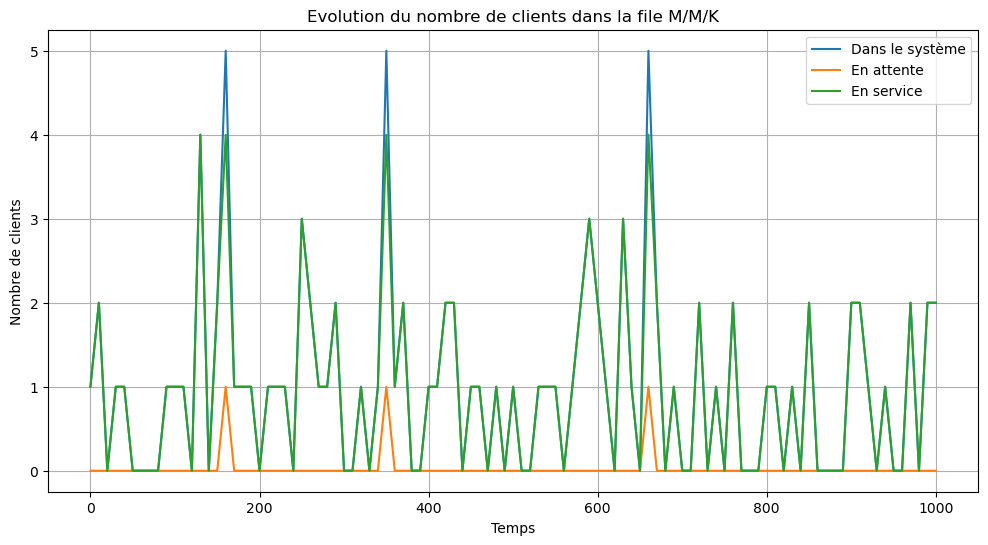

In [6]:
# Paramètres de la file M/M/K
lambda_arr = 1.0  # Taux d'arrivée des pushs
mu_1 = 1.2       # Taux de service des serveurs
K = 4            # Nombre de serveurs
gen = np.random.default_rng(seed=42)

# Créer une instance de la file M/M/K
mmk_queue = mmk(lamda=lambda_arr, mu=mu_1, k=K, gen=gen, test_z=1000)

# Simuler la file d'attente
mmk_queue.run()

# Afficher les statistiques
print("\nStatistiques de la file M/M/K:")
print(mmk_queue.stats())

# Calculer les comptages à intervalles réguliers
counts_df = mmk_queue.counts(t_intervals=10)

# Tracer l'évolution du nombre de clients dans le système
plt.figure(figsize=(12, 6))
plt.plot(counts_df.index, counts_df['ag_in_sys'], label='Dans le système')
plt.plot(counts_df.index, counts_df['ag_in_queue'], label='En attente')
plt.plot(counts_df.index, counts_df['ag_in_service'], label='En service')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients dans la file M/M/K')
plt.legend()
plt.grid(True)
plt.show()


Nous allons maintenant implémenter la file d'attente M/M/1.

In [ ]:
class mm1():
    """
    A class representing an M/M/1 queue system for processing student results

    Attributes:
        lamda (float): Arrival rate of results
        mu (float): Service rate of the server
        gen (np.random): Random number generator
        test_z (int): Number of results to simulate
        tops (pd.DataFrame): DataFrame containing timing data for each result
    """

    def __init__(self, lamda, mu, gen, test_z=100, previous_tops=None):
        """
        Initialize M/M/1 queue system.

        Args:
            lamda: Arrival rate of results
            mu: Service rate of server
            gen: Random number generator
            test_z: Number of results to simulate
        """
        # Queue parameters
        self.lamda = lamda
        self.mu = mu
        self.k = 1
        self.gen = gen
        self.t_size = test_z

        # Initialize timing DataFrame
        if previous_tops is None:
            self.tops = pd.DataFrame(
                index=range(test_z),
                columns=['t_arrival', 't_service_start', 't_departure'],
                data=np.zeros((test_z, 3))
            )
        else:
            self.tops = previous_tops

    def run(self):
        """
        Simulate the M/M/1 queue system.

        For each result:
        1. Generate arrival time based on exponential interarrival times
        2. Find first available server
        3. Generate service time from exponential distribution
        4. Calculate departure time

        Also computes waiting time, service time and total sojourn time for each result.
        """
        print("Running the M/M/1 queue simulation")

        # Add timing columns
        self.tops["t_waiting"] = np.zeros(self.t_size)
        self.tops["t_service"] = np.zeros(self.t_size)
        self.tops["t_sojourn"] = np.zeros(self.t_size)

        # Track server availability times
        server_available = np.zeros(self.k)

        # Process first result
        self.tops.loc[0, "t_service"] = self.gen.exponential(1/self.mu)
        self.tops.loc[0, "t_service_start"] = self.tops.loc[0, "t_arrival"]
        self.tops.loc[0, "t_waiting"] = 0.0
        self.tops.loc[0, "t_departure"] = self.tops.loc[0, "t_service_start"] + self.tops.loc[0, "t_service"]
        self.tops.loc[0, "t_sojourn"] = self.tops.loc[0, "t_waiting"] + self.tops.loc[0, "t_service"]
        server_available[0] = self.tops.loc[0, "t_departure"]

        # Process remaining results
        for i in range(1, self.t_size):
            # Find available server
            server_idx = np.argmin(server_available)

            # Calculate service start time
            self.tops.loc[i, "t_service_start"] = max(server_available[server_idx], self.tops.loc[i, "t_arrival"])

            # Calculate waiting and service times
            self.tops.loc[i, "t_waiting"] = self.tops.loc[i, "t_service_start"] - self.tops.loc[i, "t_arrival"]
            self.tops.loc[i, "t_service"] = self.gen.exponential(1/self.mu)

            # Calculate departure time
            self.tops.loc[i, "t_departure"] = self.tops.loc[i, "t_service_start"] + self.tops.loc[i, "t_service"]
            self.tops.loc[i, "t_sojourn"] = self.tops.loc[i, "t_waiting"] + self.tops.loc[i, "t_service"]

            # Update server availability
            server_available[server_idx] = self.tops.loc[i, "t_departure"]

    def counts(self, t_intervals):
        """
        Compute number of results in system at regular time intervals.

        Args:
            t_intervals: Time interval size for measurements

        Returns:
            DataFrame with counts of results in system, queue and service
        """
        t_max = self.tops["t_departure"].max()
        t_points = np.arange(0, t_max, t_intervals)

        counts = pd.DataFrame(
            index=t_points,
            columns=['ag_in_sys', 'ag_in_queue', 'ag_in_service'],
            data=np.zeros((len(t_points), 3))
        )

        for t in t_points:
            in_sys = ((self.tops["t_arrival"] <= t) & (self.tops["t_departure"] > t)).sum()
            in_queue = ((self.tops["t_arrival"] <= t) & (self.tops["t_service_start"] > t)).sum()
            in_service = ((self.tops["t_service_start"] <= t) & (self.tops["t_departure"] > t)).sum()

            counts.loc[t] = [in_sys, in_queue, in_service]

        return counts

    def stats(self):
        """
        Compute summary statistics for the queue simulation.

        Returns:
            DataFrame with mean sojourn time, waiting time, service time and arrival/departure times
        """
        # Calculate mean statistics
        stats = pd.DataFrame(
            index=['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time'],
            columns=['value'],
            data=[
                self.tops["t_sojourn"].mean(),
                self.tops["t_waiting"].mean(),
                self.tops["t_service"].mean()
            ]
        )

        # Add arrival and departure times
        arrivals_departures = pd.DataFrame({
            'Arrival Time': self.tops["t_arrival"],
            'Departure Time': self.tops["t_departure"]
        })

        return stats, arrivals_departures

Testons la file d'attente M/M/1.

Running the M/M/1 queue simulation

Statistiques de la file M/M/1:
(                        value
mean_sojourn_time  418.722165
mean_waiting_time  417.876867
mean_service_time    0.845298,      Arrival Time  Departure Time
0             0.0        2.003507
1             0.0        3.950332
2             0.0        5.937633
3             0.0        6.170795
4             0.0        6.242826
..            ...             ...
995           0.0      840.403603
996           0.0      841.733168
997           0.0      843.782152
998           0.0      844.977421
999           0.0      845.298417

[1000 rows x 2 columns])


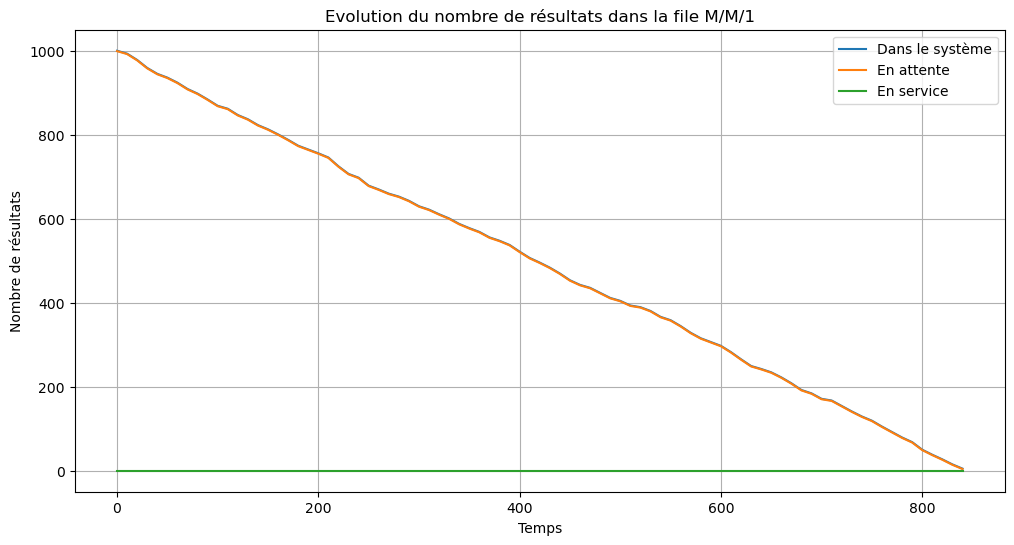

In [8]:
# Paramètres de la file M/M/1
lambda_arr = 1.0  # Taux d'arrivée des pushs
mu_1 = 1.2       # Taux de service du serveur
gen = np.random.default_rng(seed=42)

# Créer une instance de la file M/M/1
mm1_queue = mm1(lamda=lambda_arr, mu=mu_1, gen=gen, test_z=1000)

# Simuler la file d'attente
mm1_queue.run()

# Afficher les statistiques
print("\nStatistiques de la file M/M/1:")
print(mm1_queue.stats())

# Calculer les comptages à intervalles réguliers
counts_df = mm1_queue.counts(t_intervals=10)

# Tracer l'évolution du nombre de résultats dans le système
plt.figure(figsize=(12, 6))
plt.plot(counts_df.index, counts_df['ag_in_sys'], label='Dans le système')
plt.plot(counts_df.index, counts_df['ag_in_queue'], label='En attente')
plt.plot(counts_df.index, counts_df['ag_in_service'], label='En service')
plt.xlabel('Temps')
plt.ylabel('Nombre de résultats')
plt.title('Evolution du nombre de résultats dans la file M/M/1')
plt.legend()
plt.grid(True)
plt.show()

Nous allons maintenant implémenter la file d'attente M/M/K avec K = 4 et la file d'attente M/M/1 avec K = 1 pour observer le comportement du système entier.

Running the M/M/K queue simulation
Running the M/M/1 queue simulation

Statistiques de la file M/M/K:
(                      value
mean_sojourn_time  0.842850
mean_waiting_time  0.004787
mean_service_time  0.838062,       Arrival Time  Departure Time
0         0.000000        2.003507
1         2.336190        4.323490
2         2.615984        2.688015
3         4.068644        5.243612
4         7.192940        7.259019
...            ...             ...
4995   4855.208707     4855.220206
4996   4855.436639     4857.111850
4997   4857.592828     4858.151958
4998   4858.069228     4858.513539
4999   4858.609153     4860.678357

[5000 rows x 2 columns])

Statistiques de la file M/M/1:
(                      value
mean_sojourn_time  6.419468
mean_waiting_time  5.572173
mean_service_time  0.847295,       Arrival Time  Departure Time
0         2.003507        2.021800
1         4.323490        5.068793
2         2.688015        5.413640
3         5.243612        7.150253
4         7.25901

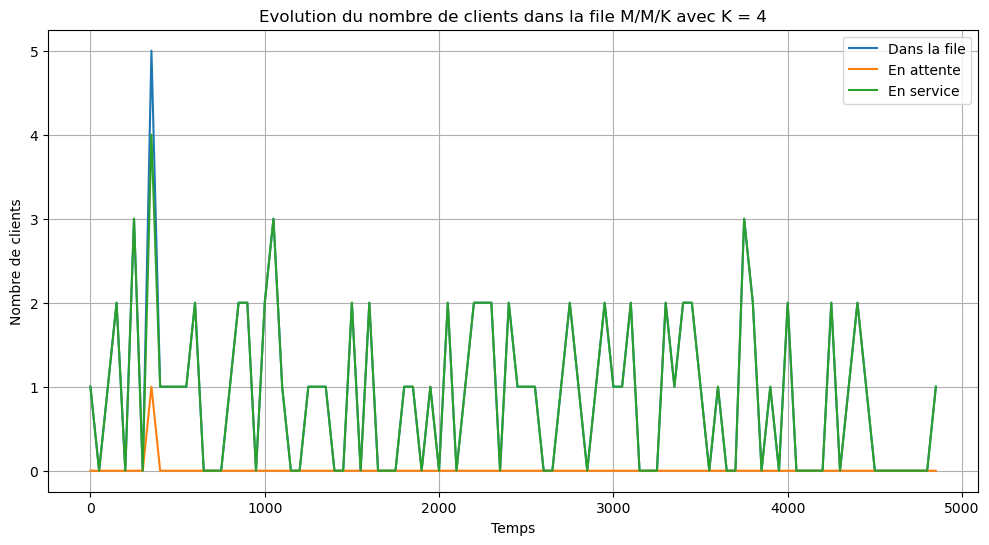

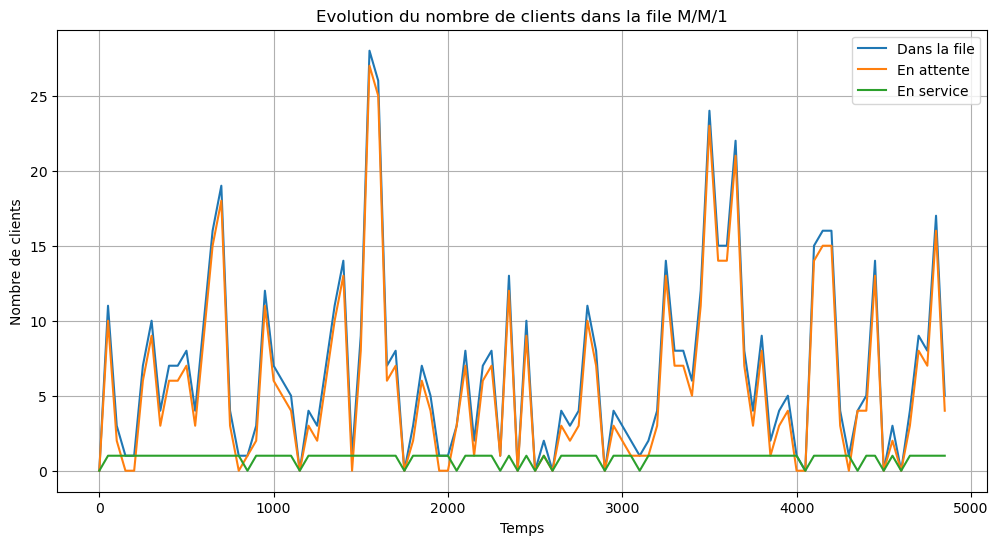

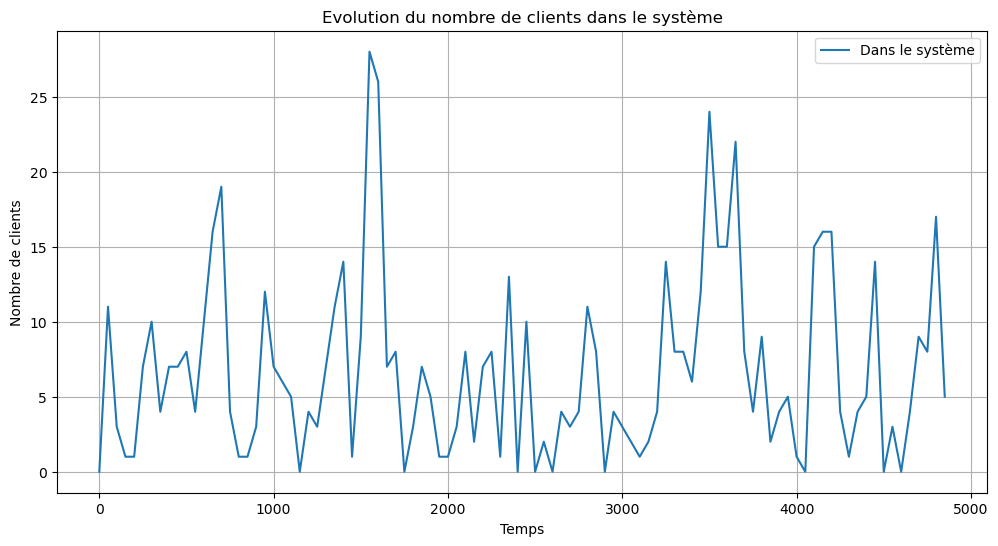

In [9]:
# Paramètres de la file M/M/K
lambda_arr = 1.0  # Taux d'arrivée des pushs
mu_1 = 1.2       # Taux de service des serveurs
K = 4            # Nombre de serveurs
gen = np.random.default_rng(seed=42)
z = 5000

# Paramètres de la file M/M/1
lambda_arr_2 = 1.0  # Taux d'arrivée des pushs
mu_2 = 1.2       # Taux de service du serveur

# Créer une instance de la file M/M/K
mmk_queue = mmk(lamda=lambda_arr, mu=mu_1, k=K, gen=gen, test_z=z)

# Simuler la file d'attente
mmk_queue.run()

prev_tops = pd.DataFrame(
                index=range(z),
                columns=['t_arrival', 't_service_start', 't_departure'],
                data=np.zeros((z, 3))
            )
prev_tops["t_arrival"] = mmk_queue.tops["t_departure"]

# Créer une instance de la file M/M/1
mm1_queue = mm1(lamda=lambda_arr_2, mu=mu_2, gen=gen, test_z=z, previous_tops=prev_tops)

# Simuler la file d'attente
mm1_queue.run()

# Afficher les statistiques
print("\nStatistiques de la file M/M/K:")
print(mmk_queue.stats())

print("\nStatistiques de la file M/M/1:")
print(mm1_queue.stats())

# Calculer les comptages à intervalles réguliers pour la file M/M/K
counts_df_k = mmk_queue.counts(t_intervals=50)

# Tracer l'évolution du nombre de clients dans la file M/M/K
plt.figure(figsize=(12, 6))
plt.plot(counts_df_k.index, counts_df_k['ag_in_sys'], label='Dans la file')
plt.plot(counts_df_k.index, counts_df_k['ag_in_queue'], label='En attente')
plt.plot(counts_df_k.index, counts_df_k['ag_in_service'], label='En service')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients dans la file M/M/K avec K = ' + str(K))
plt.legend()
plt.grid(True)
plt.show()

# Calculer les comptages à intervalles réguliers pour la file M/M/1
counts_df_1 = mm1_queue.counts(t_intervals=50)

# Tracer l'évolution du nombre de clients dans la file M/M/1
plt.figure(figsize=(12, 6))
plt.plot(counts_df_1.index, counts_df_1['ag_in_sys'], label='Dans la file')
plt.plot(counts_df_1.index, counts_df_1['ag_in_queue'], label='En attente')
plt.plot(counts_df_1.index, counts_df_1['ag_in_service'], label='En service')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients dans la file M/M/1')
plt.legend()
plt.grid(True)
plt.show()

# Tracer l'évolution du nombre de clients dans le système
plt.figure(figsize=(12, 6))
plt.plot(counts_df_1.index, counts_df_1['ag_in_sys'], label='Dans le système')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients dans le système')
plt.legend()
plt.grid(True)
plt.show()

## 2.

Etant donnée que l'hypothèse d'une file d'attente infinie est impossible, nous allons implémenter les files d'attentes M/M/K et M/M/1 avec une taille de file finie.

Commençons par la file d'attente M/M/K.

In [ ]:
class mmk_finite():
    """
    A class representing an M/M/K queue system with finite queue size for processing student pushes by K servers

    Attributes:
        lamda (float): Arrival rate of student pushes
        mu (float): Service rate of K servers
        k (int): Number of servers
        Ks (int): Maximum queue size
        gen (np.random): Random number generator
        test_z (int): Number of pushes to simulate
        tops (pd.DataFrame): DataFrame containing timing data for each push
        refused_pushes (int): Counter for refused pushes due to queue size limit
    """

    def __init__(self, lamda, mu, k, Ks, gen, test_z=100):
        """
        Initialize M/M/K queue system with finite queue.

        Args:
            lamda: Arrival rate of student pushes
            mu: Service rate of servers
            k: Number of servers
            Ks: Maximum queue size
            gen: Random number generator
            test_z: Number of pushes to simulate
        """
        # Queue parameters
        self.lamda = lamda
        self.mu = mu
        self.k = k
        self.Ks = Ks
        self.gen = gen
        self.t_size = test_z
        self.refused_pushes = 0

        # Initialize timing DataFrame
        self.tops = pd.DataFrame(
            index=range(test_z),
            columns=['t_arrival', 't_service_start', 't_departure'],
            data=np.zeros((test_z, 3))
        )

    def run(self):
        """
        Simulate the M/M/K queue system with finite queue size.

        For each push:
        1. Generate arrival time based on exponential interarrival times
        2. Check if queue size limit is exceeded
        3. If accepted, find first available server
        4. Generate service time from exponential distribution
        5. Calculate departure time

        Also computes waiting time, service time and total sojourn time for each accepted push.
        """
        print("Running the M/M/K queue simulation with finite queue size")

        # Add timing columns
        self.tops["t_waiting"] = np.zeros(self.t_size)
        self.tops["t_service"] = np.zeros(self.t_size)
        self.tops["t_sojourn"] = np.zeros(self.t_size)

        # Track server availability times
        server_available = np.zeros(self.k)

        # Process first push
        self.tops.loc[0, "t_arrival"] = 0.0
        self.tops.loc[0, "t_waiting"] = 0.0
        self.tops.loc[0, "t_service_start"] = 0.0
        self.tops.loc[0, "t_service"] = self.gen.exponential(1/self.mu)
        self.tops.loc[0, "t_departure"] = self.tops.loc[0, "t_service"]
        self.tops.loc[0, "t_sojourn"] = self.tops.loc[0, "t_service"]
        server_available[0] = self.tops.loc[0, "t_departure"]

        # Process remaining pushes
        for i in range(1, self.t_size):
            # Generate arrival time
            self.tops.loc[i, "t_arrival"] = self.tops.loc[i-1, "t_arrival"] + self.gen.exponential(1/self.lamda)

            # Count pushes currently in queue
            current_time = self.tops.loc[i, "t_arrival"]
            in_queue = ((self.tops["t_arrival"] <= current_time) &
                       (self.tops["t_service_start"] > current_time)).sum()

            # Check if queue size limit is exceeded
            if in_queue >= self.Ks:
                self.refused_pushes += 1
                continue

            # Find first available server
            server_idx = np.argmin(server_available)

            # Calculate service start time
            self.tops.loc[i, "t_service_start"] = max(server_available[server_idx], self.tops.loc[i, "t_arrival"])

            # Calculate waiting and service times
            self.tops.loc[i, "t_waiting"] = self.tops.loc[i, "t_service_start"] - self.tops.loc[i, "t_arrival"]
            self.tops.loc[i, "t_service"] = self.gen.exponential(1/self.mu)

            # Calculate departure time
            self.tops.loc[i, "t_departure"] = self.tops.loc[i, "t_service_start"] + self.tops.loc[i, "t_service"]
            self.tops.loc[i, "t_sojourn"] = self.tops.loc[i, "t_waiting"] + self.tops.loc[i, "t_service"]

            # Update server availability
            server_available[server_idx] = self.tops.loc[i, "t_departure"]

    def counts(self, t_intervals):
        """
        Compute number of pushes in system at regular time intervals.

        Args:
            t_intervals: Time interval size for measurements

        Returns:
            DataFrame with counts of pushes in system, queue and service
        """
        t_max = self.tops["t_departure"].max()
        t_points = np.arange(0, t_max, t_intervals)

        counts = pd.DataFrame(
            index=t_points,
            columns=['ag_in_sys', 'ag_in_queue', 'ag_in_service'],
            data=np.zeros((len(t_points), 3))
        )

        for t in t_points:
            in_sys = ((self.tops["t_arrival"] <= t) & (self.tops["t_departure"] > t)).sum()
            in_queue = ((self.tops["t_arrival"] <= t) & (self.tops["t_service_start"] > t)).sum()
            in_service = ((self.tops["t_service_start"] <= t) & (self.tops["t_departure"] > t)).sum()

            counts.loc[t] = [in_sys, in_queue, in_service]

        return counts

    def stats(self):
        """
        Compute summary statistics for the queue simulation.

        Returns:
            DataFrame with mean sojourn time, waiting time, service time, refused pushes count
            and arrival/departure times
        """
        # Calculate mean statistics
        stats = pd.DataFrame(
            index=['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time', 'refused_pushes'],
            columns=['value'],
            data=[
                self.tops["t_sojourn"].mean(),
                self.tops["t_waiting"].mean(),
                self.tops["t_service"].mean(),
                self.refused_pushes
            ]
        )

        # Add arrival and departure times
        arrivals_departures = pd.DataFrame({
            'Arrival Time': self.tops["t_arrival"],
            'Departure Time': self.tops["t_departure"]
        })

        return stats, arrivals_departures

Running the M/M/K queue simulation with finite queue size

Statistiques de la file M/M/K:
(                      value
mean_sojourn_time  1.076702
mean_waiting_time  0.204990
mean_service_time  0.871713
refused_pushes     7.000000,      Arrival Time  Departure Time
0        0.000000        2.003507
1        2.336190        4.323490
2        2.615984        2.688015
3        4.068644        5.243612
4        7.192940        7.259019
..            ...             ...
995    972.191300      972.473038
996    972.523198      973.466256
997    974.486079      975.167108
998    974.762562      974.853584
999    975.302647      975.367002

[1000 rows x 2 columns])


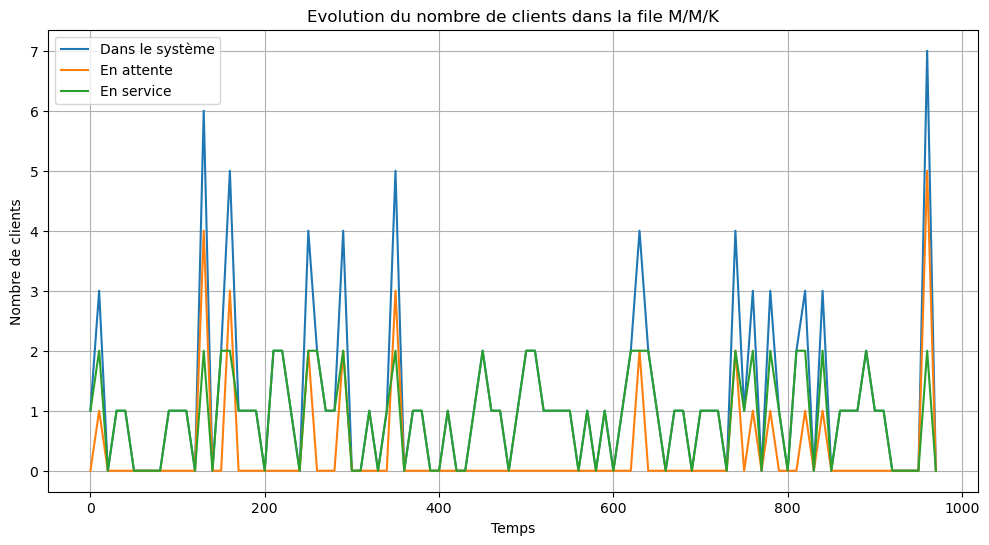

In [11]:
# Paramètres de la file M/M/K
lambda_arr = 1.0  # Taux d'arrivée des pushs
mu_1 = 1.2       # Taux de service des serveurs
K = 2            # Nombre de serveurs
gen = np.random.default_rng(seed=42)

# Créer une instance de la file M/M/K
mmk_queue = mmk_finite(lamda=lambda_arr, mu=mu_1, k=K, Ks=5, gen=gen, test_z=1000)

# Simuler la file d'attente
mmk_queue.run()

# Afficher les statistiques
print("\nStatistiques de la file M/M/K:")
print(mmk_queue.stats())

# Calculer les comptages à intervalles réguliers
counts_df = mmk_queue.counts(t_intervals=10)

# Tracer l'évolution du nombre de clients dans le système
plt.figure(figsize=(12, 6))
plt.plot(counts_df.index, counts_df['ag_in_sys'], label='Dans le système')
plt.plot(counts_df.index, counts_df['ag_in_queue'], label='En attente')
plt.plot(counts_df.index, counts_df['ag_in_service'], label='En service')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients dans la file M/M/K')
plt.legend()
plt.grid(True)
plt.show()


Implémentons maintenant la file d'attente M/M/1 avec une taille de file finie.

In [ ]:
class mm1_finite():
    """
    A class representing an M/M/1 queue system with finite queue capacity for processing student results

    Attributes:
        lamda (float): Arrival rate of results
        mu (float): Service rate of the server
        gen (np.random): Random number generator
        test_z (int): Number of results to simulate
        Kf (int): Maximum queue capacity
        tops (pd.DataFrame): DataFrame containing timing data for each result
        refused_pushes (int): Counter for refused pushes due to queue capacity
    """

    def __init__(self, lamda, mu, gen, Kf, test_z=100, previous_tops=None):
        """
        Initialize M/M/1 queue system with finite capacity.

        Args:
            lamda: Arrival rate of results
            mu: Service rate of server
            gen: Random number generator
            Kf: Maximum queue capacity
            test_z: Number of results to simulate
        """
        # Queue parameters
        self.lamda = lamda
        self.mu = mu
        self.k = 1
        self.Kf = Kf
        self.gen = gen
        self.t_size = test_z
        self.refused_pushes = 0

        # Initialize timing DataFrame
        if previous_tops is None:
            self.tops = pd.DataFrame(
                index=range(test_z),
                columns=['t_arrival', 't_service_start', 't_departure'],
                data=np.zeros((test_z, 3))
            )
        else:
            self.tops = previous_tops

    def run(self):
        """
        Simulate the M/M/1 queue system with finite capacity.

        For each result:
        1. Generate arrival time based on exponential interarrival times
        2. Check if queue capacity is exceeded
        3. Find first available server if accepted
        4. Generate service time from exponential distribution
        5. Calculate departure time

        Also computes waiting time, service time and total sojourn time for each result.
        """
        print("Running the M/M/1 queue simulation with finite capacity")

        # Add timing columns
        self.tops["t_waiting"] = np.zeros(self.t_size)
        self.tops["t_service"] = np.zeros(self.t_size)
        self.tops["t_sojourn"] = np.zeros(self.t_size)

        # Track server availability times
        server_available = np.zeros(self.k)

        # Process first result
        self.tops.loc[0, "t_service"] = self.gen.exponential(1/self.mu)
        self.tops.loc[0, "t_service_start"] = self.tops.loc[0, "t_arrival"]
        self.tops.loc[0, "t_waiting"] = 0.0
        self.tops.loc[0, "t_departure"] = self.tops.loc[0, "t_service_start"] + self.tops.loc[0, "t_service"]
        self.tops.loc[0, "t_sojourn"] = self.tops.loc[0, "t_waiting"] + self.tops.loc[0, "t_service"]
        server_available[0] = self.tops.loc[0, "t_departure"]

        # Process remaining results
        for i in range(1, self.t_size):
            # Check queue capacity
            in_queue = ((self.tops["t_arrival"] <= self.tops.loc[i, "t_arrival"]) &
                       (self.tops["t_service_start"] > self.tops.loc[i, "t_arrival"])).sum()

            if in_queue >= self.Kf:
                self.refused_pushes += 1
                continue

            # Find available server
            server_idx = np.argmin(server_available)

            # Calculate service start time
            self.tops.loc[i, "t_service_start"] = max(server_available[server_idx], self.tops.loc[i, "t_arrival"])

            # Calculate waiting and service times
            self.tops.loc[i, "t_waiting"] = self.tops.loc[i, "t_service_start"] - self.tops.loc[i, "t_arrival"]
            self.tops.loc[i, "t_service"] = self.gen.exponential(1/self.mu)

            # Calculate departure time
            self.tops.loc[i, "t_departure"] = self.tops.loc[i, "t_service_start"] + self.tops.loc[i, "t_service"]
            self.tops.loc[i, "t_sojourn"] = self.tops.loc[i, "t_waiting"] + self.tops.loc[i, "t_service"]

            # Update server availability
            server_available[server_idx] = self.tops.loc[i, "t_departure"]

    def counts(self, t_intervals):
        """
        Compute number of results in system at regular time intervals.

        Args:
            t_intervals: Time interval size for measurements

        Returns:
            DataFrame with counts of results in system, queue and service
        """
        t_max = self.tops["t_departure"].max()
        t_points = np.arange(0, t_max, t_intervals)

        counts = pd.DataFrame(
            index=t_points,
            columns=['ag_in_sys', 'ag_in_queue', 'ag_in_service'],
            data=np.zeros((len(t_points), 3))
        )

        for t in t_points:
            in_sys = ((self.tops["t_arrival"] <= t) & (self.tops["t_departure"] > t)).sum()
            in_queue = ((self.tops["t_arrival"] <= t) & (self.tops["t_service_start"] > t)).sum()
            in_service = ((self.tops["t_service_start"] <= t) & (self.tops["t_departure"] > t)).sum()

            counts.loc[t] = [in_sys, in_queue, in_service]

        return counts

    def stats(self):
        """
        Compute summary statistics for the queue simulation.

        Returns:
            DataFrame with mean sojourn time, waiting time, service time, refused pushes
            and arrival/departure times
        """
        # Calculate mean statistics
        stats = pd.DataFrame(
            index=['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time', 'refused_pushes'],
            columns=['value'],
            data=[
                self.tops["t_sojourn"].mean(),
                self.tops["t_waiting"].mean(),
                self.tops["t_service"].mean(),
                self.refused_pushes
            ]
        )

        # Add arrival and departure times
        arrivals_departures = pd.DataFrame({
            'Arrival Time': self.tops["t_arrival"],
            'Departure Time': self.tops["t_departure"]
        })

        return stats, arrivals_departures

Running the M/M/1 queue simulation with finite capacity

Statistiques de la file M/M/1:
(                        value
mean_sojourn_time    0.031758
mean_waiting_time    0.024305
mean_service_time    0.007453
refused_pushes     994.000000,      Arrival Time  Departure Time
0             0.0        2.003507
1             0.0        3.950332
2             0.0        5.937633
3             0.0        6.170795
4             0.0        6.242826
..            ...             ...
995           0.0        0.000000
996           0.0        0.000000
997           0.0        0.000000
998           0.0        0.000000
999           0.0        0.000000

[1000 rows x 2 columns])


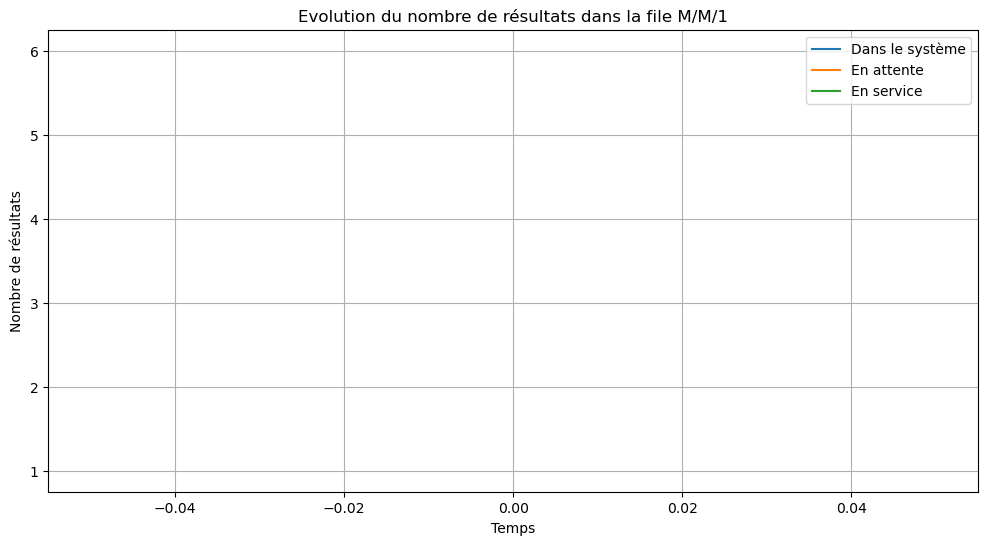

In [13]:
# Paramètres de la file M/M/1
lambda_arr = 1.0  # Taux d'arrivée des pushs
mu_1 = 1.2       # Taux de service du serveur
gen = np.random.default_rng(seed=42)

# Créer une instance de la file M/M/1
mm1_queue = mm1_finite(lamda=lambda_arr, mu=mu_1, gen=gen, Kf=5, test_z=1000)

# Simuler la file d'attente
mm1_queue.run()

# Afficher les statistiques
print("\nStatistiques de la file M/M/1:")
print(mm1_queue.stats())

# Calculer les comptages à intervalles réguliers
counts_df = mm1_queue.counts(t_intervals=10)

# Tracer l'évolution du nombre de résultats dans le système
plt.figure(figsize=(12, 6))
plt.plot(counts_df.index, counts_df['ag_in_sys'], label='Dans le système')
plt.plot(counts_df.index, counts_df['ag_in_queue'], label='En attente')
plt.plot(counts_df.index, counts_df['ag_in_service'], label='En service')
plt.xlabel('Temps')
plt.ylabel('Nombre de résultats')
plt.title('Evolution du nombre de résultats dans la file M/M/1')
plt.legend()
plt.grid(True)
plt.show()

Testons maintenant le système complet avec les deux files d'attentes finies.

Running the M/M/K queue simulation with finite queue size
Running the M/M/1 queue simulation with finite capacity

Statistiques de la file M/M/K:
(                      value
mean_sojourn_time  0.842850
mean_waiting_time  0.004787
mean_service_time  0.838062
refused_pushes     0.000000,       Arrival Time  Departure Time
0         0.000000        2.003507
1         2.336190        4.323490
2         2.615984        2.688015
3         4.068644        5.243612
4         7.192940        7.259019
...            ...             ...
4995   4855.208707     4855.220206
4996   4855.436639     4857.111850
4997   4857.592828     4858.151958
4998   4858.069228     4858.513539
4999   4858.609153     4860.678357

[5000 rows x 2 columns])

Statistiques de la file M/M/1:
(                      value
mean_sojourn_time  6.419468
mean_waiting_time  5.572173
mean_service_time  0.847295
refused_pushes     0.000000,       Arrival Time  Departure Time
0         2.003507        2.021800
1         4.323490    

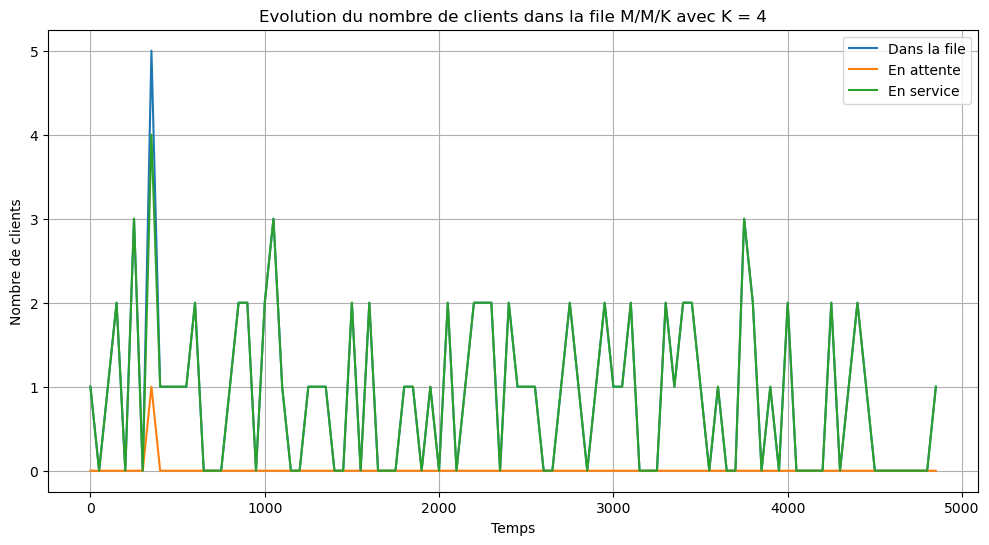

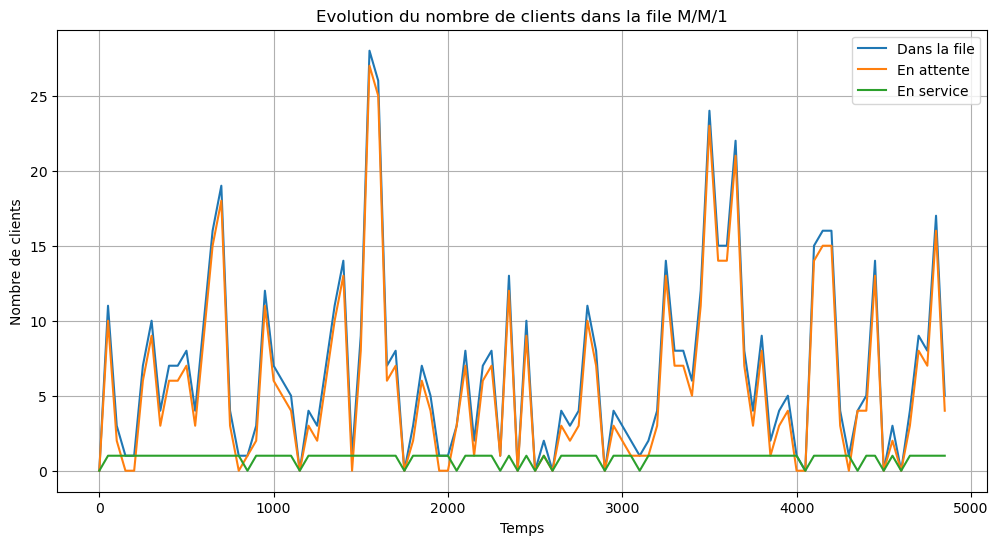

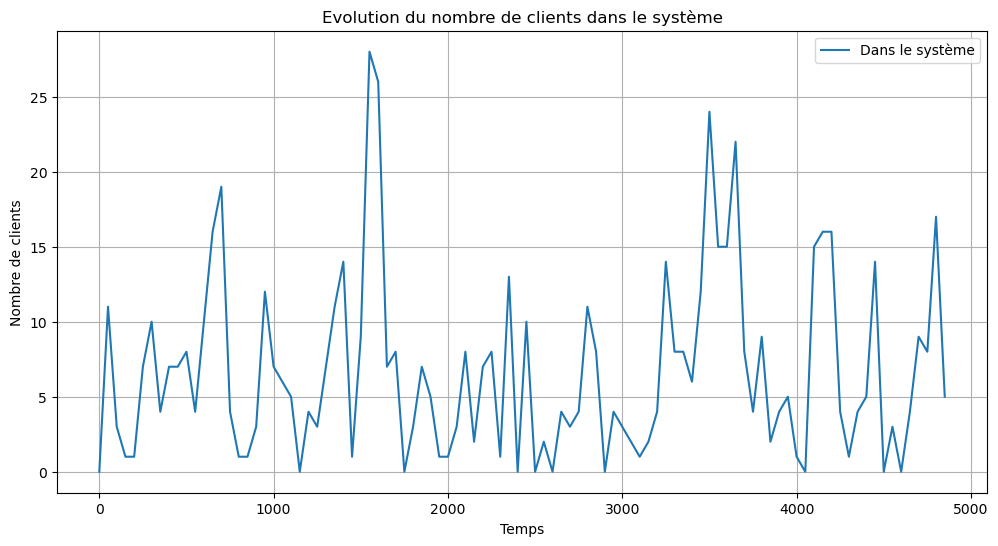

In [16]:
# Paramètres de la file M/M/K
lambda_arr = 1.0  # Taux d'arrivée des pushs
mu_1 = 1.2       # Taux de service des serveurs
K = 4            # Nombre de serveurs
gen = np.random.default_rng(seed=42)
z = 5000
Ks = 5
Kf = 40

# Paramètres de la file M/M/1
lambda_arr_2 = 1.0  # Taux d'arrivée des pushs
mu_2 = 1.2       # Taux de service du serveur

# Créer une instance de la file M/M/K
mmk_queue = mmk_finite(lamda=lambda_arr, mu=mu_1, k=K, Ks=Ks, gen=gen, test_z=z)

# Simuler la file d'attente
mmk_queue.run()

prev_tops = pd.DataFrame(
                index=range(z),
                columns=['t_arrival', 't_service_start', 't_departure'],
                data=np.zeros((z, 3))
            )
prev_tops["t_arrival"] = mmk_queue.tops["t_departure"]

# Créer une instance de la file M/M/1
mm1_queue = mm1_finite(lamda=lambda_arr_2, mu=mu_2, gen=gen, Kf=Kf, test_z=z, previous_tops=prev_tops)

# Simuler la file d'attente
mm1_queue.run()

# Afficher les statistiques
print("\nStatistiques de la file M/M/K:")
print(mmk_queue.stats())

print("\nStatistiques de la file M/M/1:")
print(mm1_queue.stats())

# Calculer les comptages à intervalles réguliers pour la file M/M/K
counts_df_k = mmk_queue.counts(t_intervals=50)

# Tracer l'évolution du nombre de clients dans la file M/M/K
plt.figure(figsize=(12, 6))
plt.plot(counts_df_k.index, counts_df_k['ag_in_sys'], label='Dans la file')
plt.plot(counts_df_k.index, counts_df_k['ag_in_queue'], label='En attente')
plt.plot(counts_df_k.index, counts_df_k['ag_in_service'], label='En service')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients dans la file M/M/K avec K = ' + str(K))
plt.legend()
plt.grid(True)
plt.show()

# Calculer les comptages à intervalles réguliers pour la file M/M/1
counts_df_1 = mm1_queue.counts(t_intervals=50)

# Tracer l'évolution du nombre de clients dans la file M/M/1
plt.figure(figsize=(12, 6))
plt.plot(counts_df_1.index, counts_df_1['ag_in_sys'], label='Dans la file')
plt.plot(counts_df_1.index, counts_df_1['ag_in_queue'], label='En attente')
plt.plot(counts_df_1.index, counts_df_1['ag_in_service'], label='En service')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients dans la file M/M/1')
plt.legend()
plt.grid(True)
plt.show()

# Tracer l'évolution du nombre de clients dans le système
plt.figure(figsize=(12, 6))
plt.plot(counts_df_1.index, counts_df_1['ag_in_sys'], label='Dans le système')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients dans le système')
plt.legend()
plt.grid(True)
plt.show()

Nous pouvons observer que le temps d'attente est légèrement plus long avec une file d'attente finie. Mais que le nombre de pushs dans la file d'attente est plus faible. La première file d'attente ne refuse aucun push car les multiples serveurs permettent de réduire le nombre de pushs en attente mais la seconde file d'attente refuse des pushs car la taille de la file est limitée.

In [24]:
mmk_refused_pushes = []
mm1_refused_pushes = []
for K in range(1, 6): # Nombre de serveurs
	mmk_refused_pushes.append([])
	mm1_refused_pushes.append([])
	for Kf in range(20, 70, 10):
		# Paramètres de la file M/M/K
		lambda_arr = 1.0  # Taux d'arrivée des pushs
		mu_1 = 1.2       # Taux de service des serveurs
		gen = np.random.default_rng(seed=42)
		z = 5000
		Ks = 5

		# Paramètres de la file M/M/1
		lambda_arr_2 = 1.0  # Taux d'arrivée des pushs
		mu_2 = 1.2       # Taux de service du serveur

		print(f"\nParamètres du benchmark: {K=} {Kf=}")

		# Créer une instance de la file M/M/K
		mmk_queue = mmk_finite(lamda=lambda_arr, mu=mu_1, k=K, Ks=Ks, gen=gen, test_z=z)

		# Simuler la file d'attente
		mmk_queue.run()

		prev_tops = pd.DataFrame(
						index=range(z),
						columns=['t_arrival', 't_service_start', 't_departure'],
						data=np.zeros((z, 3))
					)
		prev_tops["t_arrival"] = mmk_queue.tops["t_departure"]

		# Créer une instance de la file M/M/1
		mm1_queue = mm1_finite(lamda=lambda_arr_2, mu=mu_2, gen=gen, Kf=Kf, test_z=z, previous_tops=prev_tops)

		# Simuler la file d'attente
		mm1_queue.run()

		mmk_refused_pushes[-1].append(mmk_queue.refused_pushes)
		mm1_refused_pushes[-1].append(mm1_queue.refused_pushes)


Paramètres du benchmark: K=1 Kf=20
Running the M/M/K queue simulation with finite queue size
Running the M/M/1 queue simulation with finite capacity

Paramètres du benchmark: K=1 Kf=30
Running the M/M/K queue simulation with finite queue size
Running the M/M/1 queue simulation with finite capacity

Paramètres du benchmark: K=1 Kf=40
Running the M/M/K queue simulation with finite queue size
Running the M/M/1 queue simulation with finite capacity

Paramètres du benchmark: K=1 Kf=50
Running the M/M/K queue simulation with finite queue size
Running the M/M/1 queue simulation with finite capacity

Paramètres du benchmark: K=1 Kf=60
Running the M/M/K queue simulation with finite queue size
Running the M/M/1 queue simulation with finite capacity

Paramètres du benchmark: K=2 Kf=20
Running the M/M/K queue simulation with finite queue size
Running the M/M/1 queue simulation with finite capacity

Paramètres du benchmark: K=2 Kf=30
Running the M/M/K queue simulation with finite queue size
Runnin

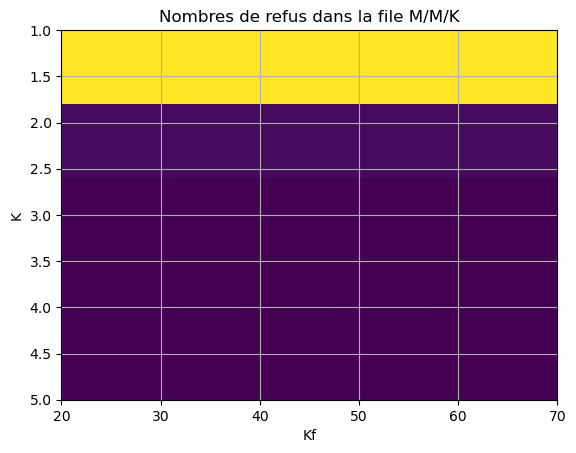

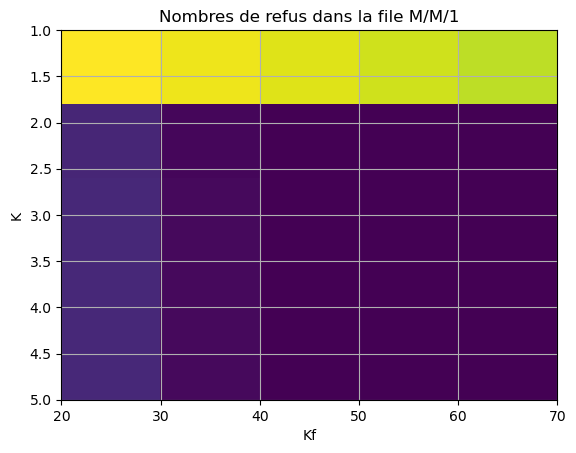

In [27]:
plt.imshow(mmk_refused_pushes, interpolation='none', extent=[20,70,5,1], aspect='auto')
plt.xlabel('Kf')
plt.ylabel('K')
plt.title('Nombres de refus dans la file M/M/K')
plt.grid(True)
plt.show()

plt.imshow(mm1_refused_pushes, interpolation='none', extent=[20,70,5,1], aspect='auto')
plt.xlabel('Kf')
plt.ylabel('K')
plt.title('Nombres de refus dans la file M/M/1')
plt.grid(True)
plt.show()